# Ensamble PyTorch + XGBoost para California Housing


Este notebook combina una red neuronal en PyTorch y un modelo XGBoost para predecir el valor de viviendas en California.
Inspirado en: [Kaggle tutorial](https://www.kaggle.com/code/megr25/california-houses-neural-network-xgboost)

Estrategia:
- Preprocesamiento conjunto para ambos modelos
- Entrenamiento independiente de red neuronal y XGBoost
- Combinar predicciones con media ponderada


In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# Cargar y preparar datos
housing = pd.read_csv("housing.csv")
housing = housing.dropna()
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]
housing = housing.drop(columns=["ocean_proximity"])

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# División
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [4]:

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)


In [5]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_valid_scaled = scaler.transform(X_valid).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)


In [6]:

X_train_tensor = torch.tensor(X_train_scaled)
X_valid_tensor = torch.tensor(X_valid_scaled).to(device)
X_test_tensor = torch.tensor(X_test_scaled).to(device)
y_train_tensor = torch.tensor(y_train_scaled)
y_valid_tensor = torch.tensor(y_valid_scaled).to(device)
y_test_tensor = torch.tensor(y_test_scaled).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

model = Net(X_train_tensor.shape[1]).to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
best_rmse = float("inf")
patience = 10
trigger = 0

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        val_pred = model(X_valid_tensor).cpu().numpy()
        val_rmse = np.sqrt(mean_squared_error(
            y_scaler.inverse_transform(y_valid_tensor.cpu().numpy()),
            y_scaler.inverse_transform(val_pred.reshape(-1, 1))
        ))
    print(f"Epoch {epoch+1}, RMSE validación (NN): {val_rmse:.2f}")
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = model.state_dict()
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_model_state)


Epoch 1, RMSE validación (NN): 62447.96
Epoch 2, RMSE validación (NN): 58279.90
Epoch 3, RMSE validación (NN): 58349.13
Epoch 4, RMSE validación (NN): 56419.57
Epoch 5, RMSE validación (NN): 55600.58
Epoch 6, RMSE validación (NN): 56586.21
Epoch 7, RMSE validación (NN): 54671.43
Epoch 8, RMSE validación (NN): 55941.05
Epoch 9, RMSE validación (NN): 54488.39
Epoch 10, RMSE validación (NN): 53843.04
Epoch 11, RMSE validación (NN): 53697.16
Epoch 12, RMSE validación (NN): 53684.97
Epoch 13, RMSE validación (NN): 53236.47
Epoch 14, RMSE validación (NN): 53582.54
Epoch 15, RMSE validación (NN): 52854.36
Epoch 16, RMSE validación (NN): 52359.98
Epoch 17, RMSE validación (NN): 51972.79
Epoch 18, RMSE validación (NN): 51969.27
Epoch 19, RMSE validación (NN): 51559.63
Epoch 20, RMSE validación (NN): 51863.35
Epoch 21, RMSE validación (NN): 52563.11
Epoch 22, RMSE validación (NN): 52139.23
Epoch 23, RMSE validación (NN): 51296.91
Epoch 24, RMSE validación (NN): 50807.28
Epoch 25, RMSE validación

<All keys matched successfully>

In [7]:

xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05)
xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

✅ RMSE test (ensamble NN + XGBoost): 48118.9181992178


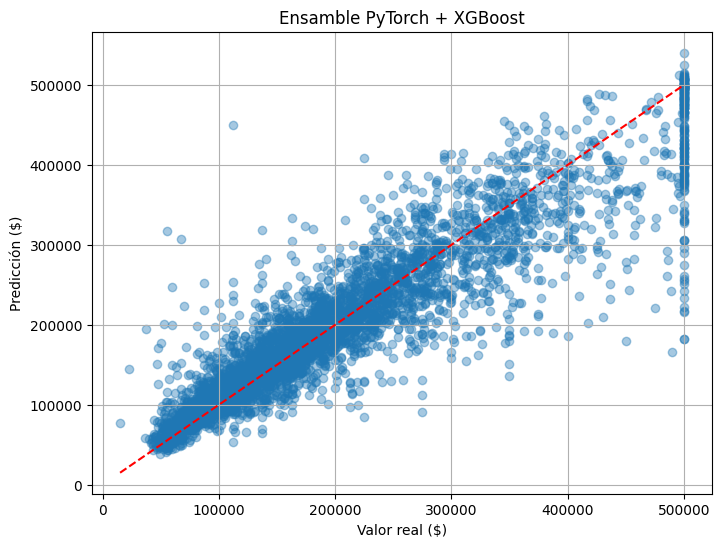

In [8]:

# Predicción sobre test
model.eval()
with torch.no_grad():
    nn_pred_scaled = model(X_test_tensor).cpu().numpy()
    nn_pred = y_scaler.inverse_transform(nn_pred_scaled.reshape(-1, 1)).flatten()

xgb_pred = xgb_model.predict(X_test_scaled)

# Promedio ponderado (ajustable)
final_pred = 0.5 * nn_pred + 0.5 * xgb_pred
rmse_ensemble = np.sqrt(mean_squared_error(y_test, final_pred))
print("✅ RMSE test (ensamble NN + XGBoost):", rmse_ensemble)

# Visualización
plt.figure(figsize=(8,6))
plt.scatter(y_test, final_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real ($)")
plt.ylabel("Predicción ($)")
plt.title("Ensamble PyTorch + XGBoost")
plt.grid(True)
plt.show()
